# Time Based Utilities and Drift Removal

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pymip.utils import google_cmip_col
from pymip.preprocessing import combined_preprocessing

In [2]:
from dask_gateway import Gateway
g = Gateway()
running_clusters = g.list_clusters()
print(running_clusters)
for c in running_clusters:
    # g.stop_cluster()
    cluster = g.connect(c.name)
    cluster.close()
print(running_clusters)

[]
[]


In [3]:
from distributed import Client
from dask_gateway import GatewayCluster
cluster = GatewayCluster()
cluster.scale(30)
cluster

In [4]:
client = Client(cluster)
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.f1abefca0c73428d92aaf87d3ccdc4ac Dashboard: /services/dask-gateway/clusters/staging.f1abefca0c73428d92aaf87d3ccdc4ac/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Loading example data

In [5]:
zkwargs = {'consolidated':True, 'use_cftime':True}
kwargs = {'zarr_kwargs':zkwargs, 'preprocess':combined_preprocessing, 'aggregate':False}

col = google_cmip_col()


cat = col.search(source_id='CanESM5-CanOE', variable_id='thetao')


ddict_historical = cat.search(experiment_id='historical').to_dataset_dict(**kwargs)
ddict_ssp585 = cat.search(experiment_id='ssp585').to_dataset_dict(**kwargs)
ddict_picontrol = cat.search(experiment_id='piControl').to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


## Pick some example data

Lets pick a particular member and define a point in x/y/z space that we will use throughout this demonstration to extract timeseries at the same point. 

In [6]:
ds_control = ddict_picontrol['CMIP.CCCma.CanESM5-CanOE.piControl.r1i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/piControl/r1i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429']
ds_historical = ddict_historical['CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r1i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429']
ds_ssp585 = ddict_ssp585['ScenarioMIP.CCCma.CanESM5-CanOE.ssp585.r1i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5-CanOE/ssp585/r1i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429']

# Pick a random location in x/y/z space to use as an exmple
roi = {'x':100,'y':220, 'lev':30}

## Visulalizing branching from the control run

Lets first start by visualizing the example point of our data

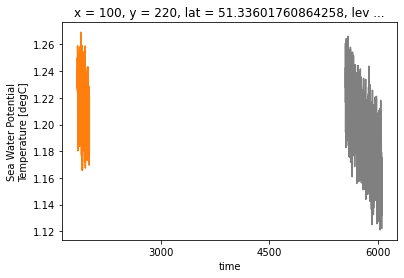

In [7]:
# ok lets just plot them together
ds_control.isel(**roi).thetao.plot(color='0.5')
ds_historical.isel(**roi).thetao.plot(color='C1')

Hmm well that doesnt look good. Its because the control run follows a different time convention. But we can check when the run was branched out exactly by looking at the metadata of the historical run:

In [8]:
{k:v for k,v in ds_historical.attrs.items() if 'parent' in k}

{'CCCma_parent_runid': 'canoecpl-007',
 'YMDH_branch_time_in_parent': '5550:01:01:00',
 'branch_time_in_parent': 1350500.0,
 'parent_activity_id': 'CMIP',
 'parent_experiment_id': 'piControl',
 'parent_mip_era': 'CMIP6',
 'parent_source_id': 'CanESM5-CanOE',
 'parent_time_units': 'days since 1850-01-01 0:0:0.0',
 'parent_variant_label': 'r1i1p2f1'}

And of course there is a tool in here that makes translating these a bit easier. We can just convert time conventions from child to parent or vice versa.

In [9]:
from pymip.drift_removal import unify_time

# the default will adjust the time convention from the first input (`parent`) to the second (`child`)
ds_control_adj, ds_historical_adj = unify_time(ds_control, ds_historical)

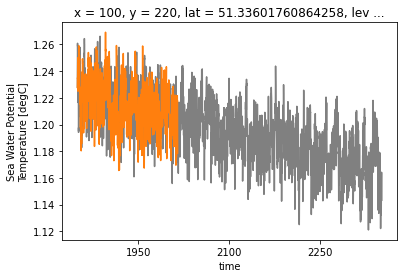

In [10]:
# ok lets just plot them together
ds_control_adj.isel(**roi).thetao.plot(color='0.5')
ds_historical_adj.isel(**roi).thetao.plot(color='C1')

That looks more sensible, but with all the wiggles its a bit tough to see. Since this run seems to be branched of at the first time step of the control ouput (the run is probably much longer, but not all data was provided to the archive), lets just cut to the first couple of timesteps to check in more detail. 

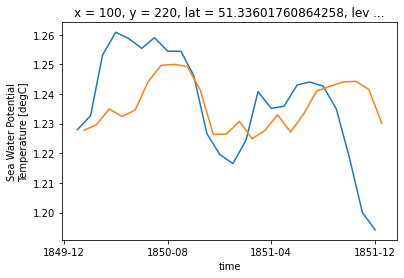

In [11]:
# ok lets just plot them together
ds_control_adj.isel(**roi, time=slice(0,24)).thetao.plot()
ds_historical_adj.isel(**roi, time=slice(0,24)).thetao.plot()

That looks pretty good, but the values are slightly shifted. This is due to the fact that for the 'untouched' CMIP6 monthly data uses a timestamp in the 'middle' of the month, whereas our adustment uses the start of the month. We can quickly adjust that:

In [12]:
from pymip.drift_removal import replace_time
# with the defaults it will just replace the dates with new ones which have time stamps at the beginning of the month.
ds_historical_adj = replace_time(ds_historical_adj) 

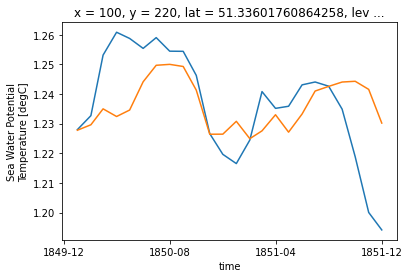

In [13]:
# ok lets just plot them together again
ds_control_adj.isel(**roi, time=slice(0,24)).thetao.plot()
ds_historical_adj.isel(**roi, time=slice(0,24)).thetao.plot()

BINGO

OK now lets look at all the members: 

In [14]:
for name, ds in ddict_historical.items():
    print(name, ds.attrs['branch_time_in_parent'])

CMIP.CCCma.CanESM5-CanOE.historical.r2i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r2i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429 1368750.0
CMIP.CCCma.CanESM5-CanOE.historical.r3i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r3i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429 1387000.0
CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r1i1p2f1/Omon/thetao/gn/v20190429/.nan.20190429 1350500.0


Hmmm, these were all branched out at a different time! This is actually quite common, but it means to visualize these we will have to convert the time into the conventions of the parent (control) run. Thats pretty easy though!

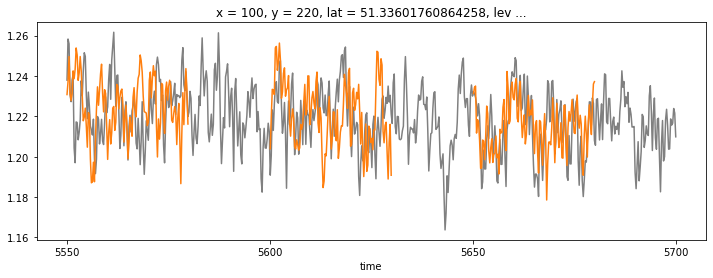

In [16]:
# replace the timestamp with the first of the month for the control run and plot
# we will also average the data yearly to remove some of the visual noise

plt.figure(figsize=[12,4])
replace_time(ds_control).isel(**roi).thetao.coarsen(time=3).mean().isel(time=slice(0,150*4)).plot(color='0.5')

# now we loop through all the historical members, adjust the time and plot them in the same way, 
# but only for the first 20 years
for name, ds in ddict_historical.items():
    _, ds_adj = unify_time(ds_control, ds, adjust_to='parent')
    ds_adj.isel(**roi).thetao.coarsen(time=3).mean().isel(time=slice(0,30*4)).plot(color='C1')

You can see that all the 'connection points' seem to match up!

## Removing control drift

This was a neat exercise, but you might have noticed that the control run shows a pretty pronounced trend (decreasing temperature). Since this is an unforced control run, we have to assume that the model is not completely equilibrated and continues to `drift`. This drift can affect the runs which are branched off this run. 

It is often desirable to remove the drift, or more precisely subtract the linear trend of the control run over the time period of the branched off runs. `pymip` makes this easy.

In this context the words `trend` and `drift` are used as follows:
- `trend` general expression for a linear trend over a timeseries
- `drift` particularly the control run trend


### Rechunking the control run

Since most CMIP6 datasets are chunked into pretty small time chunks, applying any operation along the time axis is very difficult to do with dask. Lets use the [rechunker](https://rechunker.readthedocs.io/en/latest/) package to write a temporary dataset that is chunked in space, not time.

We will save this (large) dataset in the [Pangeo scratch bucket](https://pangeo.io/cloud.html#scratch-bucket)

In [19]:
# setting up the scratch bucket
import os
import fsspec
PANGEO_SCRATCH = os.environ['PANGEO_SCRATCH']+'cmip6_pp_demo'
path = f'{PANGEO_SCRATCH}/test_rechunked.zarr'
temp_path = f'{PANGEO_SCRATCH}/test_rechunked_temp.zarr'
mapper = fsspec.get_mapper(path)
mapper_temp = fsspec.get_mapper(temp_path)

In [20]:
if not mapper.fs.exists(path):
    # recompute the rechunked data into the scratch bucket (is only triggered when the temporary store was erased)
    
    # Remove the temp store if for some reason that still exists
    if mapper.fs.exists(temp_path):
        mapper.fs.rm(temp_path, recursive=True)
    from rechunker import rechunk
    target_chunks = {
        'thetao': {'time':6012, 'lev':1, 'x':3, 'y':291},
        'x': {'x':3},
        'y': {'y':291},
        'lat': {'x':3, 'y':291},
        'lev': {'lev':1},
        'lon': {'x':3, 'y':291},
        'time': {'time':6012}, 
    }
    max_mem = '1GB'

    array_plan = rechunk(ds_control[['thetao']], target_chunks, max_mem, mapper, temp_store=mapper_temp)
    array_plan.execute(retries=10)
    
ds_control_rechunked = xr.open_zarr(mapper, use_cftime=True)
ds_control_rechunked    

<xarray.Dataset>
Dimensions:  (lev: 45, time: 6012, x: 360, y: 291)
Coordinates:
    lat      (y, x) float64 dask.array<chunksize=(291, 3), meta=np.ndarray>
  * lev      (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
    lon      (y, x) float64 dask.array<chunksize=(291, 3), meta=np.ndarray>
  * time     (time) object 5550-01-16 12:00:00 ... 6050-12-16 12:00:00
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * y        (y) int32 0 1 2 3 4 5 6 7 8 ... 282 283 284 285 286 287 288 289 290
Data variables:
    thetao   (time, lev, y, x) float32 dask.array<chunksize=(6012, 1, 291, 3), meta=np.ndarray>
Attributes: (12/58)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-pictrl
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   5550:01:01:00
    ...                          ...
    title:                       CanESM5-CanOE output prepared for CMIP6
    tracking_id:                 hdl:21.14100/8b3a90ee-6bf3-496a-ba59-648dded...
    variable_id:                 thetao
    variant_label:               r1i1p2f1
    version:                     v20190429
    version_id:                  v20190429

### Calculating the drift over the control run

In [21]:
from pymip.drift_removal import calculate_drift, remove_trend

In [22]:
drift = calculate_drift(ds_control_rechunked, ds_historical, 'thetao') 
drift = drift.load() # This takes a bit, but it is worth loading this small output to avoid repeated computation
drift

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarrayutils/utils.py:85: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stats = xr.apply_ufunc(


<xarray.Dataset>
Dimensions:           (bnds: 2, lev: 45, x: 360, y: 291)
Coordinates:
  * lev               (lev) float64 3.047 9.454 16.36 ... 5.375e+03 5.625e+03
  * x                 (x) int32 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * y                 (y) int32 0 1 2 3 4 5 6 7 ... 284 285 286 287 288 289 290
    trend_time_range  (bnds) <U19 '5550-01-16 12:00:00' '5799-12-16 12:00:00'
Dimensions without coordinates: bnds
Data variables:
    thetao            (lev, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes: (12/58)
    CCCma_model_hash:            932b659de600c6a0e94f619abaf9cc79eabcd337
    CCCma_parent_runid:          canoecpl-007
    CCCma_pycmor_hash:           3ecdc18eb7c1f7fbce0346850f41adf815d9fb66
    CCCma_runid:                 c2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variant_label:               r1i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/05f0fb20-3395-4112-af53-d1b9241...
    version_id:                  v20190429
    intake_esm_varname:          None
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1...

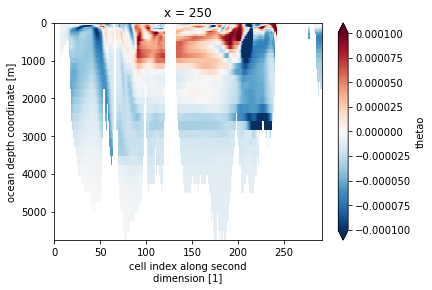

In [23]:
drift.thetao.isel(x=250).plot(yincrease=False, robust=True)

`drift` represents the slope of a linear regression at every grid point of the model. For demonstration purposes we will stick with the one grid point that we defined above. Lets first check if the trend seems right...

In [24]:
start = drift.trend_time_range.isel(bnds=0).data.tolist()
stop = drift.trend_time_range.isel(bnds=1).data.tolist()
time = xr.cftime_range(start, stop, freq='1MS')

# cut the control it to the time over which the trend was calculated
ds_control_cut = ds_control_rechunked.sel(time=slice(start, stop))

# use the linear slope from the same point to construct a trendline
trendline = xr.DataArray((np.arange(len(time)) * drift.thetao.isel(**roi).data) + ds_control_cut.thetao.isel(**roi, time=0).data, dims=['time'], coords={'time':time})

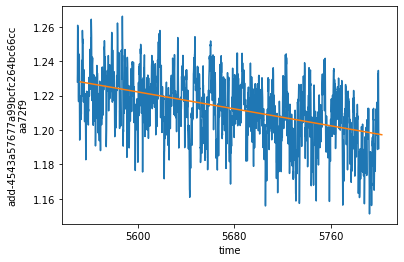

In [28]:
ds_control_cut.thetao.isel(**roi).plot()
trendline.plot()

### Removing the drift from various datasets

We can remove this slope from either the control run 

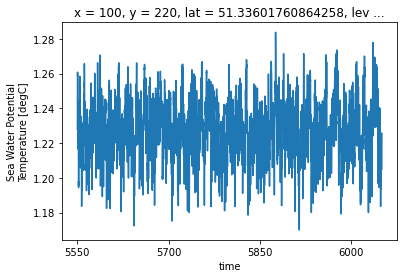

In [29]:
control_detrended = remove_trend(ds_control, drift, 'thetao', ref_date=str(ds_control.time.data[0]))
control_detrended.isel(**roi).plot()

Sure thats nice, but that's not why we are here. Lets actually remove the trend from the control run from *another* run.

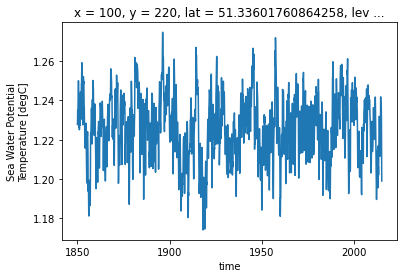

In [30]:
ds_historical_dedrifted = remove_trend(ds_historical, drift, 'thetao', ref_date=str(ds_historical.time.data[0]))
ds_historical_dedrifted.isel(**roi).plot()

In [31]:
ds_historical_dedrifted

<xarray.DataArray (time: 1980, lev: 45, y: 291, x: 360)>
dask.array<sub, shape=(1980, 45, 291, 360), dtype=float32, chunksize=(5, 45, 291, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * x        (x) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * y        (y) int32 0 1 2 3 4 5 6 7 8 ... 282 283 284 285 286 287 288 289 290
    lat      (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * lev      (lev) float64 3.047 9.454 16.36 ... 5.126e+03 5.375e+03 5.625e+03
    lon      (y, x) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
Attributes:
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Diagnostic should be contributed even for models using co...
    long_name:      Sea Water Potential Temperature
    original_name:  votemper
    standard_name:  sea_water_potential_temperature
    units:          degC
    drift_removed:  linear_trend_CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1...

In [32]:
ds_historical_dedrifted.attrs['drift_removed']

'linear_trend_CMIP.CCCma.CanESM5-CanOE.historical.r1i1p2f1.Omon.gn.v20190429_5550-01-16 12:00:00_5799-12-16 12:00:00'

Note that the attributes now contain informations about the dataset and time frame over which the removed trend was computed!

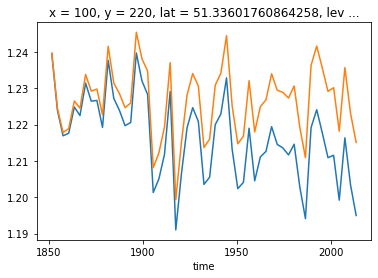

In [33]:
ds_historical.isel(**roi).thetao.coarsen(time=36).mean().plot()
ds_historical_dedrifted.isel(**roi).coarsen(time=36).mean().plot()

You can also remove the trend from the ssp585 scenario in a way that is consistent with the historical run. The key here is the `ref_date` input. 
This should be set to the 'branching' timestep of the historical run for both experiments (which is `1850-01-01` for most CMIP6 historical experiments). 

In [36]:
ds_ssp585_dedrifted = remove_trend(
    ds_ssp585,
    drift,
    'thetao',
    ref_date=str(ds_historical.time.data[0]) 
    # Note that the ref_date is still the first time point of the *historical*run. 
    # This ensures that the scenario is treated as an extension of the historical 
    # run and the offset is calculated appropriately
)

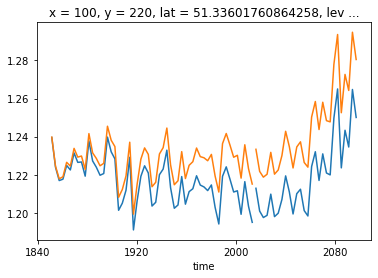

In [35]:
ds_historical.isel(**roi).thetao.coarsen(time=36, boundary='trim').mean().plot(color='C0', label='raw data')
ds_ssp585.isel(**roi).thetao.coarsen(time=36, boundary='trim').mean().plot(color='C0')
ds_historical_dedrifted.isel(**roi).coarsen(time=36, boundary='trim').mean().plot(color='C1', label='control drift removed')
ds_ssp585_dedrifted.isel(**roi).coarsen(time=36, boundary='trim').mean().plot(color='C1')

> We are working on calculating the linear trends for common variables and store them in the cloud. Then you only have to apply `remove_trend` and not the expensive `calculate_drift` anymore. Stay tuned!